In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(17,8)})
import sklearn
%matplotlib inline
#Adjust the display
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
from sklearn.model_selection import train_test_split, KFold , StratifiedKFold , cross_val_score , cross_validate , GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics        import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix , make_scorer , precision_recall_curve , roc_curve,roc_auc_score 
from sklearn.preprocessing   import LabelEncoder ,StandardScaler, MinMaxScaler
import statistics

In [9]:
df_transaction = pd.read_csv('../ieee-fraud-detection/train_transaction.csv')

In [4]:
df_id = pd.read_csv('../ieee-fraud-detection/train_identity.csv')

In [16]:
df_transaction['card1'].value_counts()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
17084        1
14620        1
11440        1
13231        1
18038        1
Name: card1, Length: 13553, dtype: int64

In [32]:
df_id['id_31'].str.replace(' \d+.?\d+','')

/var/folders/v3/m9cgmw1d3qs7ppj4ltvx26pc0000gn/T/ipykernel_4268/403834220.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_id['id_31'].str.replace(' \d+.?\d+','')


0            samsung browser
1              mobile safari
2                     chrome
3                     chrome
4                     chrome
                 ...        
144228    chrome for android
144229    chrome for android
144230    chrome for android
144231                chrome
144232    chrome for android
Name: id_31, Length: 144233, dtype: object

In [5]:
df_transaction['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

<AxesSubplot:>

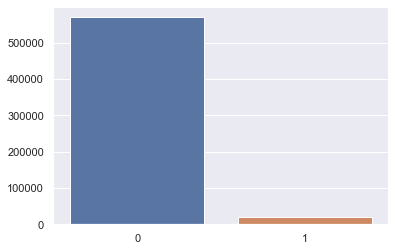

In [6]:
# class imbalance
x=df_transaction['isFraud'].value_counts()
sns.barplot(x=x.index,y= x.values)


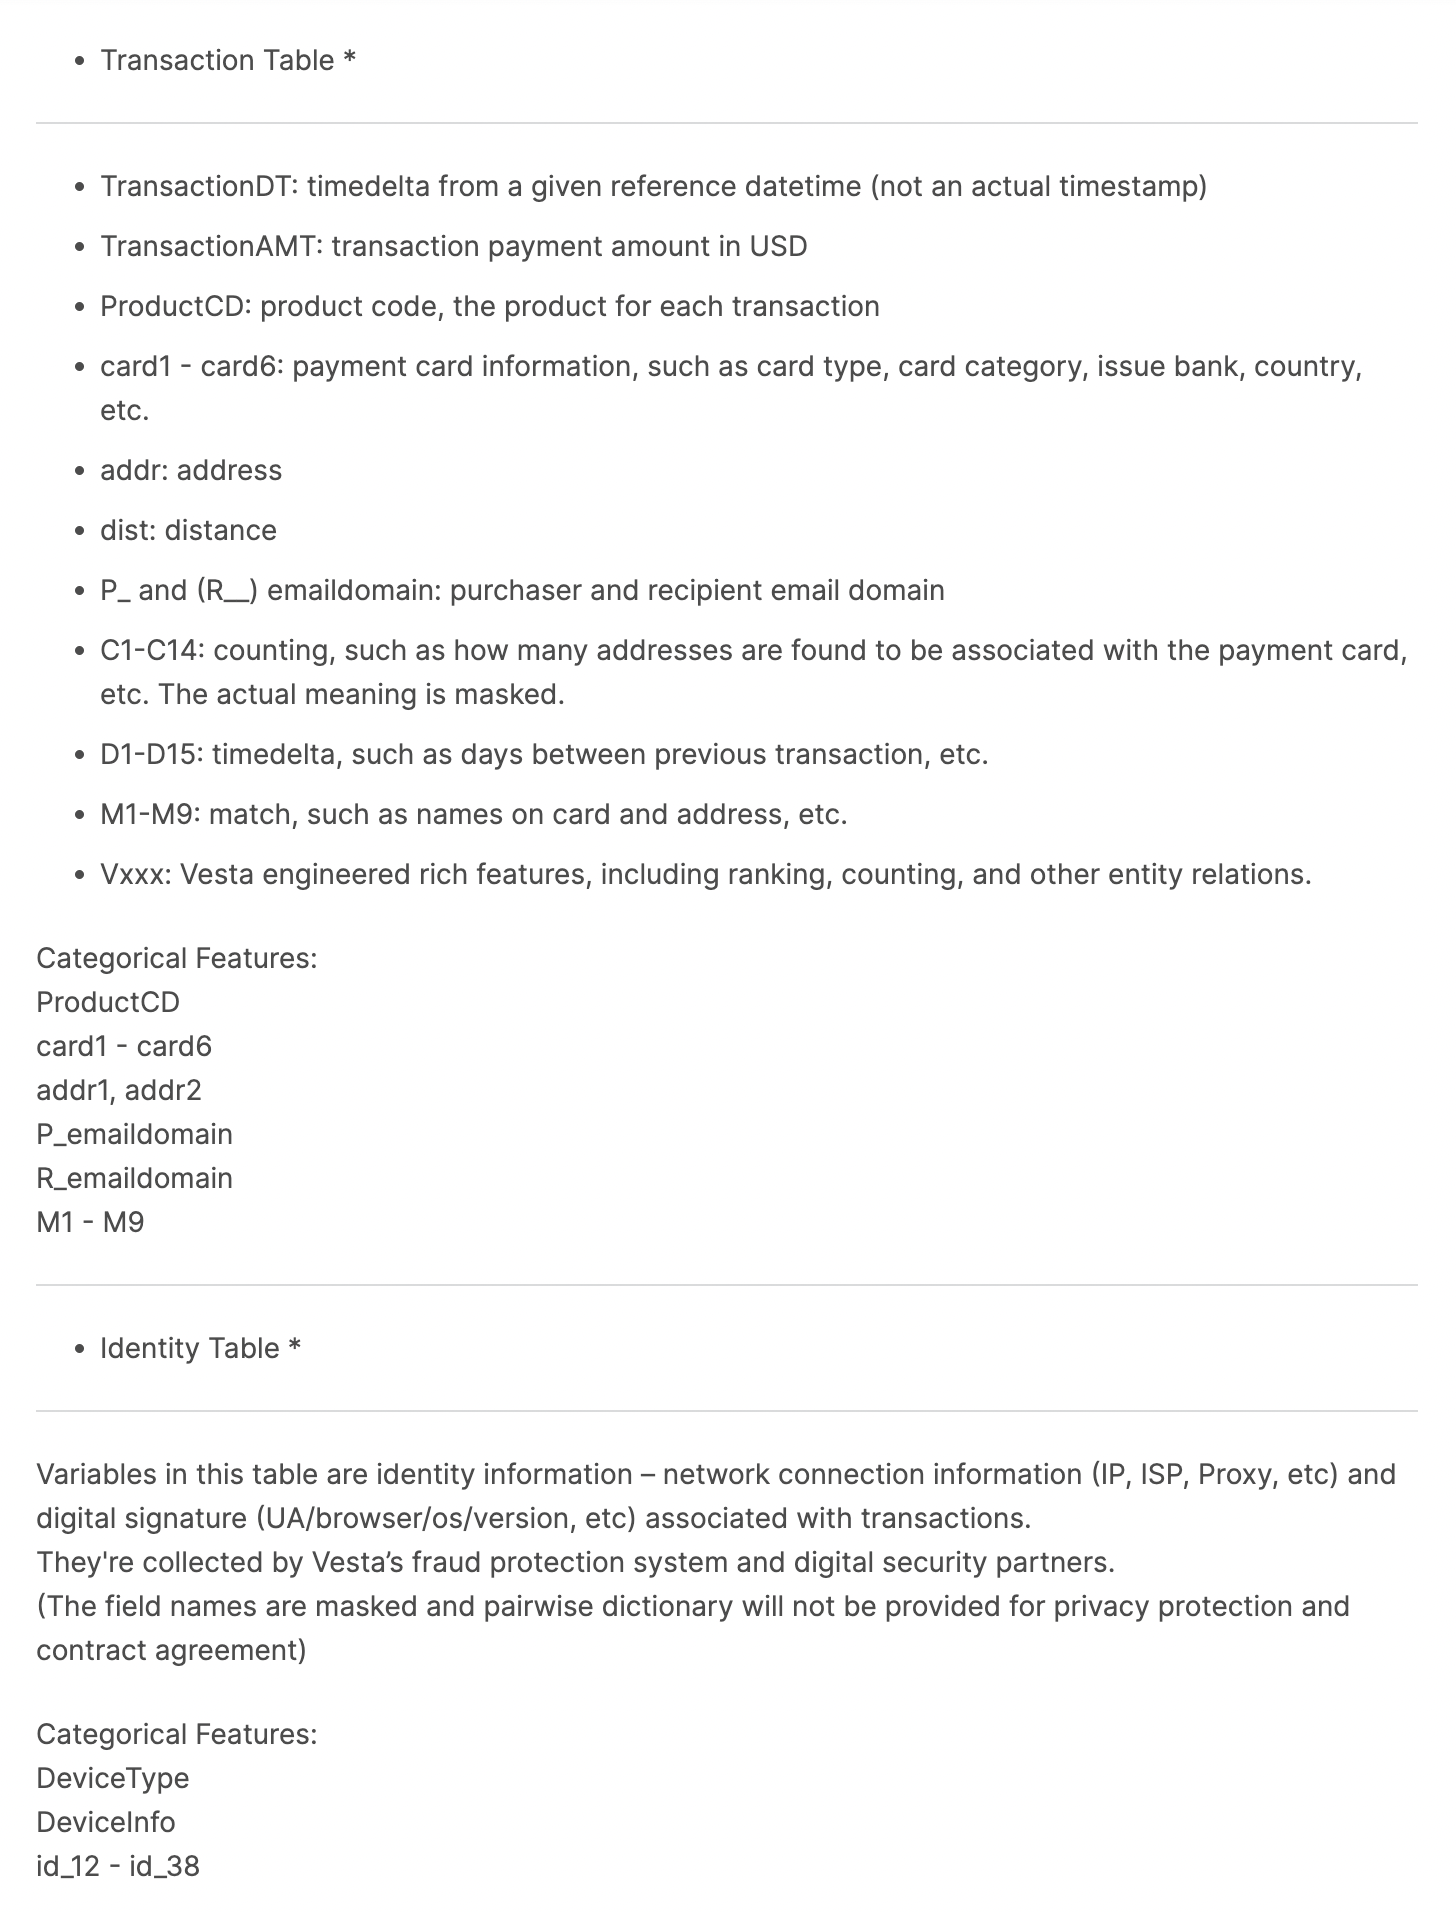

In [39]:
print(df_transaction.columns.to_list())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

### EDA

### timedelta

In [73]:
df_transaction['TransactionDT']

0            86400
1            86401
2            86469
3            86499
4            86506
            ...   
590535    15811047
590536    15811049
590537    15811079
590538    15811088
590539    15811131
Name: TransactionDT, Length: 590540, dtype: int64

### M features

- 대부분 값들이 True or False로만 이루어져있다
- M4 컬럼만 다른 컬럼 값을 가르키고있다

In [63]:
M_columns = [column for column in df_transaction.columns if column.startswith('M')]
df_transaction[M_columns].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### V features
- numeric values

In [64]:
V_columns = [column for column in df_transaction.columns if column.startswith('V')]
df_transaction[V_columns].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# 다 무조건 0과 1로 이루어져있는거 아니다
df_transaction[V_columns]['V2'].unique()

array([ 1., nan,  2.,  3.,  0.,  4.,  5.,  6.,  7.,  8.])

### C featuers
- categorical
- 존나 신기한게 card 정보들은 missing value들이 하나도 없다

In [70]:
C_columns = [column for column in df_transaction.columns if column.startswith('C')]
df_transaction[C_columns].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


### D featuers
- time에 관한 데이터라고 하는데 

In [71]:
D_columns = [column for column in df_transaction.columns if column.startswith('D')]
df_transaction[D_columns].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### card column

In [21]:
card_columns = [i for i in df_cleaned.columns if i.startswith('c') ]
df_transaction['card4']

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [28]:
index_bool = df_transaction['card6'].isna()


,card1,card2,card3,card4,card5,card6
9686,16794,NaN,NaN,NaN,NaN,NaN
28994,5178,NaN,NaN,NaN,NaN,NaN
29013,5178,NaN,NaN,NaN,NaN,NaN
93342,6091,NaN,150.0,american express,NaN,NaN
107595,6091,NaN,150.0,american express,NaN,NaN
...,...,...,...,...,...,...
526601,16752,NaN,NaN,NaN,NaN,NaN
526603,16132,NaN,NaN,NaN,NaN,NaN
526604,14393,NaN,NaN,NaN,NaN,NaN
535821,6091,NaN,150.0,american express,NaN,NaN


### 데이터 전처리

In [58]:
# missing value가 너무 많은얘들은 버리자
many_null_cols = [col for col in df_transaction.columns if df_transaction[col].isnull().sum() / df_transaction.shape[0] > 0.3]
df_extracted = df_transaction.drop(columns=many_null_cols)
df_extracted
many_null_cols

['dist1',
 'dist2',
 'R_emaildomain',
 'D2',
 'D3',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D11',
 'D12',
 'D13',
 'D14',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',

In [ ]:
df

In [75]:
X_train_val , X_test, y_train_val, y_test = train_test_split(df_transaction.drop(columns='isFraud'),df_transaction['isFraud'],train_size=0.8,stratify=df_transaction['isFraud'])
X_train_val.shape , X_test.shape, y_train_val.shape, y_test.shape

((472432, 393), (118108, 393), (472432,), (118108,))

In [76]:
X_train_val

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
45754,3032754,1101532,80.000,S,15063,514.0,150.0,visa,226.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274452,3261452,6654217,125.000,R,11207,361.0,150.0,visa,226.0,debit,...,0.0,125.0,125.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0
499603,3486603,13104826,29.000,W,12501,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373542,3360542,9310460,107.950,W,6730,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
575491,3562491,15287214,54.000,W,4436,174.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584994,3571994,15637292,107.950,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297639,3284639,7345582,117.000,W,16132,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485388,3472388,12631344,65.046,C,11201,103.0,185.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75985,3062985,1654964,100.000,R,10486,514.0,150.0,mastercard,219.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 사용할 컬럼들 

In [77]:
v_columns = [i for i in X_train_val.columns if i.startswith('V') ]
c_columns = [i for i in X_train_val.columns if i.startswith('C') ]
card_columns = ['card4','card6']
rest = ['ProductCD','TransactionAmt']
X_train_val_cleaned = X_train_val[rest+card_columns+v_columns+c_columns]
X_train_val_cleaned['card6'] = X_train_val_cleaned['card6'].apply(lambda x: 'rest' if x not in ['credit','debit'] else x)
X_train_val_cleaned[['card4']] = X_train_val_cleaned[['card4']].replace(np.nan,'rest')
X_train_val_cleaned[c_columns+v_columns] =X_train_val_cleaned[c_columns+v_columns].fillna(X_train_val[c_columns+v_columns].mean())

/var/folders/v3/m9cgmw1d3qs7ppj4ltvx26pc0000gn/T/ipykernel_4268/18731665.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cleaned['card6'] = X_train_val_cleaned['card6'].apply(lambda x: 'rest' if x not in ['credit','debit'] else x)
/Users/iganghui/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [83]:
X_train_val_cleaned = pd.get_dummies(X_train_val_cleaned,columns=categorical_var)

In [81]:
X_test = X_test[rest+card_columns+v_columns+c_columns]
X_test['card6'] = X_test ['card6'].apply(lambda x: 'rest' if x not in ['credit','debit'] else x)
X_test[['card4']] = X_test [['card4']].replace(np.nan,'rest')
X_test[c_columns+v_columns] =X_test[c_columns+v_columns].fillna(X_train_val[c_columns+v_columns].mean())
X_test

/var/folders/v3/m9cgmw1d3qs7ppj4ltvx26pc0000gn/T/ipykernel_4268/2359220225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['card6'] = X_test ['card6'].apply(lambda x: 'rest' if x not in ['credit','debit'] else x)
/Users/iganghui/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,ProductCD,TransactionAmt,card4,card6,V1,V2,V3,V4,V5,V6,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
433223,W,59.000,visa,debit,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,17.0,3.0
253984,W,280.000,mastercard,debit,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,60.0,3.0
254096,W,32.970,visa,debit,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0
465759,W,39.000,visa,debit,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
81775,C,13.118,mastercard,credit,0.999956,1.04542,1.078535,0.846604,0.877194,1.045922,...,0.0,1.0,1.0,3.0,0.0,2.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456212,W,77.000,mastercard,debit,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,...,1.0,5.0,0.0,0.0,2.0,0.0,3.0,1.0,70.0,4.0
108901,H,40.000,visa,credit,0.999956,1.04542,1.078535,0.846604,0.877194,1.045922,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
331156,W,41.000,mastercard,debit,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,1.0
173764,W,40.000,visa,debit,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


In [84]:
X_test = pd.get_dummies(X_test,columns=categorical_var)

In [60]:
v_columns = [i for i in df_extracted.columns if i.startswith('V') ]
c_columns = [i for i in df_extracted.columns if i.startswith('C') ]
card_columns = ['card4','card6']
rest = ['ProductCD','TransactionAmt']

In [61]:
df_cleaned = df_extracted[rest+card_columns+v_columns+c_columns]

In [62]:
df_cleaned['card6'] = df_cleaned['card6'].apply(lambda x: 'rest' if x not in ['credit','debit'] else x)
df_cleaned[['card4']] = df_cleaned[['card4']].replace(np.nan,'rest')
df_cleaned[c_columns+v_columns] = df_cleaned[c_columns+v_columns].fillna(df_extracted[c_columns+v_columns].mean())

/var/folders/v3/m9cgmw1d3qs7ppj4ltvx26pc0000gn/T/ipykernel_4268/162467437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['card6'] = df_cleaned['card6'].apply(lambda x: 'rest' if x not in ['credit','debit'] else x)
/Users/iganghui/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [92]:
df_cleaned
df_transaction['isFraud']

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

### Modelling

In [70]:
# 범주형 변수
categorical_var = ['card4','card6','ProductCD']

features = pd.get_dummies(df_cleaned,columns=categorical_var)
#features = df_cleaned
label = df_extracted['isFraud']

In [72]:
X_train_val , X_test, y_train_val, y_test = train_test_split(features,label,train_size=0.8,stratify=label)
X_train_val.shape , X_test.shape, y_train_val.shape, y_test.shape

((472432, 197), (118108, 197), (472432,), (118108,))

In [73]:
X_train , X_validation, y_train, y_validation = train_test_split(X_train_val,y_train_val,train_size=0.8,stratify=y_train_val)


In [78]:
X_train_val.head()

,TransactionAmt,V12,V13,V14,V15,V16,V17,V18,V19,V20,...,card6_charge card,card6_credit,card6_debit,card6_debit or credit,card6_rest,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
392177,59.0,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,...,0,0,1,0,0,0,0,0,0,1
560137,59.0,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,...,0,0,1,0,0,0,0,0,0,1
284407,250.0,0.559711,0.599166,0.9995,0.122342,0.12346,0.13404,0.135363,0.816371,0.847843,...,0,1,0,0,0,0,1,0,0,0
52798,100.0,0.000000,0.000000,1.0000,0.000000,0.00000,1.00000,1.000000,1.000000,1.000000,...,0,1,0,0,0,0,1,0,0,0
80834,75.0,0.559711,0.599166,0.9995,0.122342,0.12346,0.13404,0.135363,0.816371,0.847843,...,0,1,0,0,0,0,0,1,0,0


In [94]:
# def plot_roc_curve(fper, tper):
#     plt.plot(fper, tper, color='red', label='ROC')
#     plt.plot([0, 1], [0, 1], color='green', linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic Curve')
#     plt.legend()
#     plt.show()
# rf_model = RandomForestClassifier(n_jobs=-1)
# rf_model.fit(X_train,y_train)

# probs = rf_model.predict_proba(X_test)
# #accuracy_score(y_test,rf_model.predict(X_test))
# prob = probs[:, 1]
# fper, tper, thresholds = roc_curve(y_test, prob)
# plot_roc_curve(fper, tper

In [87]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train_val_cleaned,y_train_val)
roc_auc_score(y_test,rf_model.predict(X_test))

0.7220755354945964

In [139]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train_val,y_train_val)
roc_auc_score(y_test,rf_model.predict(X_test))

0.7128993017695725

In [61]:
# 이렇게 하는거 자체가 잘못됬다
from sklearn.model_selection import TimeSeriesSplit
rf_model = RandomForestClassifier(n_jobs=-1)
kfold = StratifiedKFold(n_splits=5,shuffle=True)
#kfold = TimeSeriesSplit(n_splits=5)
cross_val_score(rf_model,X_train_val,y_train_val,cv=kfold,scoring='roc_auc',n_jobs=-1)

array([0.88155447, 0.88215526, 0.8866931 , 0.88577623, 0.88269808])

In [ ]:
train

In [15]:
df_id.head()
df_id.dropna(axis=1)

,TransactionID,id_01,id_12
0,2987004,0.0,NotFound
1,2987008,-5.0,NotFound
2,2987010,-5.0,NotFound
3,2987011,-5.0,NotFound
4,2987016,0.0,NotFound
...,...,...,...
144228,3577521,-15.0,NotFound
144229,3577526,-5.0,NotFound
144230,3577529,-20.0,NotFound
144231,3577531,-5.0,NotFound


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,2987000,0,86400,68.50,W,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,2987001,0,86401,29.00,W,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,2987002,0,86469,59.00,W,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2987003,0,86499,50.00,W,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,2987004,0,86506,50.00,H,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0
590536,3577536,0,15811049,39.50,W,10444,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
590537,3577537,0,15811079,30.95,W,12037,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
590538,3577538,0,15811088,117.00,W,7826,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0


In [24]:
label = data['isFraud']
features = data[['TransactionAmt','ProductCD']+[f'C{i}'for i in range(1,15)]]

In [34]:
X_train , X_test, y_train, y_test = train_test_split(features,label,test_size=0.2,stratify= label)

In [39]:
X_train

,TransactionAmt,ProductCD,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
337901,134.950,W,2.0,3.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,23.0,2.0
134497,44.541,C,1.0,6.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0
182386,171.000,W,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,1.0
242077,250.000,W,12.0,7.0,0.0,0.0,7.0,7.0,0.0,0.0,3.0,0.0,7.0,0.0,18.0,10.0
295958,103.950,W,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,15.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546054,107.950,W,1.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
124062,47.950,W,5.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,5.0,0.0,5.0,0.0,6.0,5.0
277163,117.000,W,2.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0
319309,13.836,C,45.0,101.0,0.0,11.0,0.0,11.0,11.0,13.0,0.0,28.0,30.0,30.0,4.0,3.0


In [ ]:
origin

In [93]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(pd.get_dummies(df_cleaned,columns=categorical_var),df_transaction['isFraud'])

RandomForestClassifier(n_jobs=-1)

In [95]:
pd.get_dummies(df_cleaned,columns=categorical_var)

,TransactionAmt,V12,V13,V14,V15,V16,V17,V18,V19,V20,...,card4_rest,card4_visa,card6_credit,card6_debit,card6_rest,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,68.50,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,...,0,0,1,0,0,0,0,0,0,1
1,29.00,0.000000,0.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,...,0,0,1,0,0,0,0,0,0,1
2,59.00,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,...,0,1,0,1,0,0,0,0,0,1
3,50.00,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,...,0,0,0,1,0,0,0,0,0,1
4,50.00,0.559711,0.599166,0.9995,0.122342,0.12346,0.13404,0.135363,0.816371,0.847843,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.00,2.000000,2.000000,1.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0,1,0,1,0,0,0,0,0,1
590536,39.50,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,...,0,0,0,1,0,0,0,0,0,1
590537,30.95,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,...,0,0,0,1,0,0,0,0,0,1
590538,117.00,1.000000,1.000000,1.0000,0.000000,0.00000,0.00000,0.000000,2.000000,2.000000,...,0,0,0,1,0,0,0,0,0,1


In [113]:
df_cleaned.iloc[:,4:].columns

Index(['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       ...
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype='object', length=183)

In [97]:
df_transaction_test = pd.read_csv('../ieee-fraud-detection/test_transaction.csv')

In [ ]:
df_transaction

In [114]:
test_features = df_transaction_test[df_cleaned.columns]
test_features[['card4']] = test_features[['card4']].replace(np.nan,'rest')
test_features['card6'] = test_features['card6'].apply(lambda x: 'rest' if x not in ['credit','debit'] else x)
test_features[df_cleaned.iloc[:,4:].columns] = test_features[df_cleaned.iloc[:,4:].columns].fillna(df_transaction[df_cleaned.iloc[:,4:].columns].mean())
test_features = pd.get_dummies(test_features,columns=categorical_var)

/Users/iganghui/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/var/folders/v3/m9cgmw1d3qs7ppj4ltvx26pc0000gn/T/ipykernel_4268/1244003996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features['card6'] = test_features['card6'].apply(lambda x: 'rest' if x not in ['credit','debit'] else x)


In [95]:
test_features.isna().sum().sum()

0

In [ ]:
df

In [115]:
test_features

,TransactionAmt,V12,V13,V14,V15,V16,V17,V18,V19,V20,...,card4_rest,card4_visa,card6_credit,card6_debit,card6_rest,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,31.950,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
1,49.000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,1,0,0,0,0,0,1
2,171.000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,1,0,0,0,0,0,1
3,284.950,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,1,0,0,0,0,0,1
4,67.950,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,94.679,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0,0,0,1,0,1,0,0,0,0
506687,12.173,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,1,0,1,0,0,0,0
506688,49.000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,1,0,0,0,0,0,1
506689,202.000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,1


In [116]:
predict = rf_model.predict(test_features)
csv_df = pd.DataFrame({'TransactionID':df_transaction_test['TransactionID'],'isFraud':predict})
csv_df = csv_df.set_index('TransactionID')

In [117]:
csv_df

,isFraud
TransactionID,
3663549,0
3663550,0
3663551,0
3663552,0
3663553,0
...,...
4170235,0
4170236,0
4170237,0


In [118]:
csv_df.to_csv('predict.csv')

In [119]:
pd.read_csv('predict.csv')

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0
